In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
t0 = 0
tf = 12
X0 = [0.5, 0.7]

In [3]:
# uncontrolled system
def lotka_volterra(X, t):
    x, y = X
    dx = x - x * y
    dy = - y + x * y
    return [dx, dy]

t = np.linspace(t0, tf, 100)
sol = odeint(lotka_volterra, X0, t)

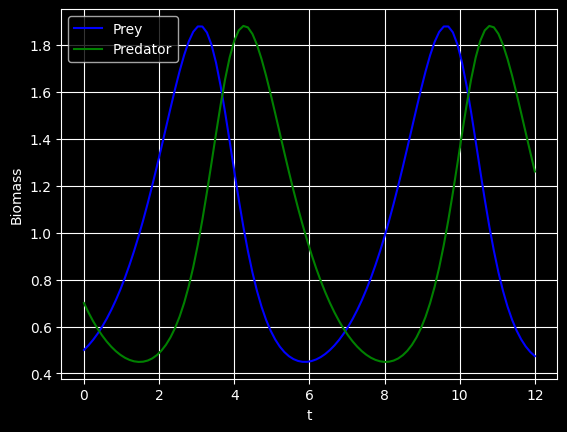

In [5]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.plot(t, sol[:, 0], 'b', label='Prey')
plt.plot(t, sol[:, 1], 'g', label='Predator')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('Biomass')
plt.grid()
plt.savefig("prey_predator_uncontrolled.png")
plt.show()

 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  6
   Intermediates:  0
   Connections  :  0
   Equations    :  5
   Residuals    :  5
 
 Number of state variables:    1980
 Number of total equations: -  1881
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    99
 
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      4.15 NLPi:   55 Dpth:    0 Lvs:    2 Obj:  1.34E+00 Gap:       NaN
Iter:     2 I:  0 Tm:      0.70 NLPi:    8 Dpth:    1 Lvs:    3 Obj:  1.34E+00 Gap:       NaN
Iter:     3 I:  0 Tm:      1.50 NLPi:   38 Dpth:    2 Lvs:    4 Obj:  1.34E+00 Gap:       NaN


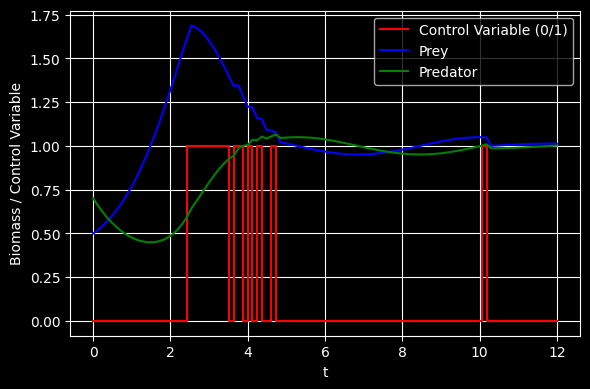

In [11]:
from gekko import GEKKO

m = GEKKO(remote=False)
m.solver_options = ['minlp_gap_tol 0.001',\
                    'minlp_max_iter_with_int_sol 100',\
                    'minlp_branch_method 1',\
                    'minlp_integer_tol 0.001',\
                    'minlp_integer_leaves 0',\
                    'minlp_maximum_iterations 200']

m.time = np.linspace(t0, tf, 100)
x0 = m.Var(value=0.5,lb=0)
x1 = m.Var(value=0.7,lb=0)
x2 = m.Var(value=0.0,lb=0)
w = m.MV(value=0,lb=0,ub=1,integer=True)
w.STATUS = 1
last = m.Param(np.zeros(100))
last.value[-1] = 1
m.Minimize(last*x2)

m.Equations([x0.dt() == x0 - x0*x1 - 0.4*x0*w,\
             x1.dt() == - x1 + x0*x1 - 0.2*x1*w,\
             x2 == m.integral((x0-1)**2 + (x1-1)**2)])

m.options.IMODE = 6
m.options.NODES = 3
m.options.SOLVER = 1
m.options.MV_TYPE = 0
m.solve()

plt.figure(figsize=(6,4))
plt.step(m.time,w.value,'r-',label='Control Variable (0/1)')
plt.plot(m.time,x0.value,'b',label=r'Prey')
plt.plot(m.time,x1.value,'g',label=r'Predator')
plt.xlabel('t'); plt.ylabel('Biomass / Control Variable')
plt.legend(loc='best'); plt.grid(); plt.tight_layout()
plt.savefig("prey_predator_controlled.png")
plt.show()